<a href="https://colab.research.google.com/github/tommymmcguire/DeerAI-540/blob/main/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing Data

In [1]:
# Remove Colab default sample_data
!rm -r ./sample_data

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import time
import copy
import numpy as np
from tqdm import tqdm
import os
import shutil
from sklearn.model_selection import train_test_split
from collections import defaultdict
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import models
import torch.nn as nn
from collections import Counter
import re

In [2]:
import os
# check if directory exists
if not os.path.exists('./drive/MyDrive/CKWRI Deer Photos/cropped images'):
  print("Directory does not exist")
else:
  print("Directory exists")

Directory exists


In [3]:
import os

# Path to the main folder containing subfolders of images
main_folder_path = './drive/MyDrive/CKWRI Deer Photos/cropped images'

# Supported image file extensions
image_extensions = {'.jpg'}

# Function to count images in a directory
def count_images_in_directory(directory):
    return sum(1 for item in os.listdir(directory)
               if os.path.isfile(os.path.join(directory, item)) and os.path.splitext(item)[1].lower() in image_extensions)

# Iterate through each subfolder and count the images
for folder in os.listdir(main_folder_path):
    full_folder_path = os.path.join(main_folder_path, folder)
    if os.path.isdir(full_folder_path):
        image_count = count_images_in_directory(full_folder_path)
        print(f"{folder}: {image_count} images")


.ipynb_checkpoints: 0 images
Doe 1810-4 years cropped: 717 images
Doe 0811-14 years cropped: 699 images
Doe 2008-2 years cropped: 740 images
Doe 0804-14 years cropped: 754 images
Doe 1505-7 years cropped: 827 images
Doe 0805-14 years cropped: 875 images
Doe 1802-4 years cropped: 1085 images
Doe 2006-2 years cropped: 1160 images
Doe 1512-7 years cropped: 1346 images
Doe 1033-12 years cropped: 1360 images
Doe 2009-2 years cropped: 1560 images
Doe 2002-2 years cropped: 1612 images
Doe 1804-4 years cropped: 1671 images
Doe 1812-4 years cropped: 2334 images
Doe 1509-7 years cropped: 2642 images
Doe 2003-2 years cropped: 2309 images


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Original folder containing all deer images
original_folder_path = './drive/MyDrive/CKWRI Deer Photos/cropped images'

# Destination folder paths
train_path = './drive/MyDrive/CKWRI Deer Photos/datasets/train'
val_path = './drive/MyDrive/CKWRI Deer Photos/datasets/val'
test_path = './drive/MyDrive/CKWRI Deer Photos/datasets/test'

# Ensure destination folders exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

def move_and_append_age(files, source_folder, destination_folder):
    # Extract age from the source folder name
    # Assuming the age is always the part right before "years cropped" in the folder name
    age = source_folder.split(' ')[-3]

    for f in files:
        # Create a new filename with the age appended
        name, ext = os.path.splitext(f)
        new_filename = f"{name}_{age}{ext}"

        # Move and rename the file
        shutil.move(os.path.join(source_folder, f), os.path.join(destination_folder, new_filename))

# Iterate through each subfolder in the original folder
for folder in os.listdir(original_folder_path):
    # Skip the .ipynb_checkpoints directory
    if folder == '.ipynb_checkpoints':
        continue

    full_folder_path = os.path.join(original_folder_path, folder)
    if os.path.isdir(full_folder_path):
        # List all images (assuming .JPG extension)
        images = [f for f in os.listdir(full_folder_path) if f.endswith('.JPG') or f.endswith('.jpg')]

        # Split the images into train, validation, and test sets
        train_val, test_images = train_test_split(images, test_size=0.1, random_state=42)
        train_images, val_images = train_test_split(train_val, test_size=0.2, random_state=42)

        # Move and rename the files to their respective directories
        move_and_append_age(train_images, full_folder_path, train_path)
        move_and_append_age(val_images, full_folder_path, val_path)
        move_and_append_age(test_images, full_folder_path, test_path)


### Dealing with issues (Doe 2003

In [7]:
import os
import shutil

def move_images_and_remove_dir(parent_directories):
    for parent_dir in parent_directories:
        # Construct the path to the 'Doe 2003-2 years cropped' directory
        cropped_dir_path = os.path.join(parent_dir, 'Doe 2003-2 years cropped')

        if os.path.exists(cropped_dir_path):
            # Move each file in the 'Doe 2003-2 years cropped' directory to the parent directory
            for filename in os.listdir(cropped_dir_path):
                src_path = os.path.join(cropped_dir_path, filename)
                dest_path = os.path.join(parent_dir, filename)
                shutil.move(src_path, dest_path)

            # Remove the now empty 'Doe 2003-2 years cropped' directory
            os.rmdir(cropped_dir_path)
            print(f"Processed and removed directory: {cropped_dir_path}")
        else:
            print(f"Directory not found: {cropped_dir_path}")

# List of parent directories (train, val, test)
parent_directories = [
    './drive/MyDrive/CKWRI Deer Photos/datasets/train',
    './drive/MyDrive/CKWRI Deer Photos/datasets/val',
    './drive/MyDrive/CKWRI Deer Photos/datasets/test'
]

# Call the function with the list of directories
move_images_and_remove_dir(parent_directories)


Processed and removed directory: ./drive/MyDrive/CKWRI Deer Photos/datasets/train/Doe 2003-2 years cropped
Processed and removed directory: ./drive/MyDrive/CKWRI Deer Photos/datasets/val/Doe 2003-2 years cropped
Processed and removed directory: ./drive/MyDrive/CKWRI Deer Photos/datasets/test/Doe 2003-2 years cropped


In [9]:
import os

def remove_images_with_name(parent_directories, keyword='Doe 2003'):
    for parent_dir in parent_directories:
        if os.path.exists(parent_dir):
            # Walk through all files and folders within the parent directory
            for root, dirs, files in os.walk(parent_dir):
                for file in files:
                    # Check if the keyword is in the file name
                    if keyword in file:
                        file_path = os.path.join(root, file)
                        os.remove(file_path)  # Delete the file
                        print(f"Removed file: {file_path}")
        else:
            print(f"Directory not found: {parent_dir}")

# List of parent directories (train, val, test)
parent_directories = [
    './drive/MyDrive/CKWRI Deer Photos/datasets/train',
    './drive/MyDrive/CKWRI Deer Photos/datasets/val',
    './drive/MyDrive/CKWRI Deer Photos/datasets/test'
]

# Call the function with the list of directories
remove_images_with_name(parent_directories)


Removed file: ./drive/MyDrive/CKWRI Deer Photos/datasets/train/Doe 2003 (427)_cropped_2003-2.JPG
Removed file: ./drive/MyDrive/CKWRI Deer Photos/datasets/train/Doe 2003 (1570)_cropped_2003-2.JPG
Removed file: ./drive/MyDrive/CKWRI Deer Photos/datasets/train/Doe 2003 (1667)_cropped_2003-2.JPG
Removed file: ./drive/MyDrive/CKWRI Deer Photos/datasets/train/Doe 2003 (1673)_cropped_2003-2.JPG
Removed file: ./drive/MyDrive/CKWRI Deer Photos/datasets/train/Doe 2003 (587)_cropped_2003-2.JPG
Removed file: ./drive/MyDrive/CKWRI Deer Photos/datasets/train/Doe 2003 (1738)_cropped_2003-2.JPG
Removed file: ./drive/MyDrive/CKWRI Deer Photos/datasets/train/Doe 2003 (1783)_cropped_2003-2.JPG
Removed file: ./drive/MyDrive/CKWRI Deer Photos/datasets/train/Doe 2003 (1790)_cropped_2003-2.JPG
Removed file: ./drive/MyDrive/CKWRI Deer Photos/datasets/train/Doe 2003 (1795)_cropped_2003-2.JPG
Removed file: ./drive/MyDrive/CKWRI Deer Photos/datasets/train/Doe 2003 (681)_cropped_2003-2.JPG
Removed file: ./drive/M

In [11]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to the specific folder containing the images to be processed
specific_folder_name = 'Doe 2003-2 years cropped new'
original_folder_path = os.path.join('./drive/MyDrive/CKWRI Deer Photos/cropped images', specific_folder_name)

# Destination folder paths
train_path = './drive/MyDrive/CKWRI Deer Photos/datasets/train'
val_path = './drive/MyDrive/CKWRI Deer Photos/datasets/val'
test_path = './drive/MyDrive/CKWRI Deer Photos/datasets/test'

# Ensure destination folders exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

def move_and_append_age(files, source_folder, destination_folder):
    # Extract age from the specific folder name, assuming the age is always the part right before "years cropped" in the folder name
    age = specific_folder_name.split(' ')[-4] + '-' + specific_folder_name.split(' ')[-3]

    for f in files:
        # Create a new filename with the age appended
        name, ext = os.path.splitext(f)
        new_filename = f"{name}_{age}{ext}"

        # Move and rename the file
        shutil.move(os.path.join(source_folder, f), os.path.join(destination_folder, new_filename))

# List all images (assuming .JPG extension)
images = [f for f in os.listdir(original_folder_path) if f.endswith('.JPG') or f.endswith('.jpg')]

# Split the images into train, validation, and test sets
train_val, test_images = train_test_split(images, test_size=0.1, random_state=42)
train_images, val_images = train_test_split(train_val, test_size=0.2, random_state=42)

# Move and rename the files to their respective directories
move_and_append_age(train_images, original_folder_path, train_path)
move_and_append_age(val_images, original_folder_path, val_path)
move_and_append_age(test_images, original_folder_path, test_path)


### Issues fixed

In [15]:
filename = "0804 -3yrs(2).jpg"  # Example filename

# Splitting the filename to extract the part after "-"
parts = filename.split('-')
age_part = parts[1]  # This should contain the age and possibly more, like "3yrs(2)"

# Further splitting to isolate the age, assuming "yrs" is always present before the age
age = ''.join(filter(str.isdigit, age_part.split('yrs')[0]))  # This extracts digits before "yrs"

new_filename = f"{parts[0]}-{age}.JPG"  # Constructing the new filename
print(new_filename)


0804 -3.JPG


In [17]:
import os
import shutil

# Source and destination directories
source_directory = './drive/MyDrive/CKWRI Deer Photos/Camera-Does'
destination_directory = './drive/MyDrive/CKWRI Deer Photos/datasets/train'

# Ensure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

def rename_and_move_images(source_dir, destination_dir):
    for filename in os.listdir(source_dir):
        if filename.endswith('.jpg') or filename.endswith('.JPG'):
            # Splitting the filename to extract the number after "-"
            parts = filename.split('-')
            age_part = parts[1]  # Contains the age and possibly more, like "3yrs(2)"
            age = ''.join(filter(str.isdigit, age_part.split('yrs')[0]))  # Extracting just the digits before "yrs"

            # Constructing the new filename
            new_filename = f"{parts[0]}-{age}.JPG"

            # Move and rename the file
            shutil.move(os.path.join(source_dir, filename), os.path.join(destination_dir, new_filename))
            print(f"Moved and renamed: {filename} to {new_filename}")

rename_and_move_images(source_directory, destination_directory)


Moved and renamed: 2003 -2yrs.JPG to 2003 -2.JPG
Moved and renamed: 1512 -7yrs(2).JPG to 1512 -7.JPG
Moved and renamed: 1505 -7yrs(2).JPG to 1505 -7.JPG
Moved and renamed: 0804 -15yrs.JPG to 0804 -15.JPG
Moved and renamed: 2202 -1yrs(2).JPG to 2202 -1.JPG
Moved and renamed: 0811 -15yrs.JPG to 0811 -15.JPG
Moved and renamed: 2008 -3yrs.JPG to 2008 -3.JPG
Moved and renamed: 2202 -1yrs(3).JPG to 2202 -1.JPG
Moved and renamed: 2202 -1yrs.JPG to 2202 -1.JPG
Moved and renamed: 2103 -2yrs.JPG to 2103 -2.JPG
Moved and renamed: 2105 -2yrs.JPG to 2105 -2.JPG
Moved and renamed: 1505 -8yrs.JPG to 1505 -8.JPG
Moved and renamed: 1812 -5yrs.JPG to 1812 -5.JPG
Moved and renamed: 2006 -3yrs.JPG to 2006 -3.JPG
Moved and renamed: 1804 -5yrs.JPG to 1804 -5.JPG
Moved and renamed: 2002 -4yrs.JPG to 2002 -4.JPG
Moved and renamed: 1505 -9yrs.JPG to 1505 -9.JPG
Moved and renamed: 1810 -6yrs.JPG to 1810 -6.JPG
Moved and renamed: 1812 -6yrs(2).JPG to 1812 -6.JPG
Moved and renamed: 2101 -3yrs.JPG to 2101 -3.JPG
M

In [4]:
import os

# Define the path to your train folder
train_folder_path = './drive/MyDrive/CKWRI Deer Photos/datasets/train'

# Iterate through each file in the train folder
for filename in os.listdir(train_folder_path):
    # Check if the filename does NOT start with 'Doe'
    if not filename.startswith('Doe'):
        # Construct the new filename by prepending 'Doe' to the original filename
        new_filename = f'Doe {filename}'

        # Construct the full source and destination paths
        src_path = os.path.join(train_folder_path, filename)
        dest_path = os.path.join(train_folder_path, new_filename)

        # Rename the file
        os.rename(src_path, dest_path)
        print(f'Renamed "{filename}" to "{new_filename}"')


Renamed "2009 -1.JPG" to "Doe 2009 -1.JPG"
Renamed "0804 -13.JPG" to "Doe 0804 -13.JPG"
Renamed "2002 -2.JPG" to "Doe 2002 -2.JPG"
Renamed "1033 -12.JPG" to "Doe 1033 -12.JPG"
Renamed "1810 -4.JPG" to "Doe 1810 -4.JPG"
Renamed "0811 -14.JPG" to "Doe 0811 -14.JPG"
Renamed "1509 -7.JPG" to "Doe 1509 -7.JPG"
Renamed "2003 -2.JPG" to "Doe 2003 -2.JPG"
Renamed "1505 -7.JPG" to "Doe 1505 -7.JPG"
Renamed "0804 -15.JPG" to "Doe 0804 -15.JPG"
Renamed "0811 -15.JPG" to "Doe 0811 -15.JPG"
Renamed "2008 -3.JPG" to "Doe 2008 -3.JPG"
Renamed "2103 -2.JPG" to "Doe 2103 -2.JPG"
Renamed "2105 -2.JPG" to "Doe 2105 -2.JPG"
Renamed "1505 -8.JPG" to "Doe 1505 -8.JPG"
Renamed "1812 -5.JPG" to "Doe 1812 -5.JPG"
Renamed "2006 -3.JPG" to "Doe 2006 -3.JPG"
Renamed "1804 -5.JPG" to "Doe 1804 -5.JPG"
Renamed "2202 -2.JPG" to "Doe 2202 -2.JPG"
Renamed "1033 -14.JPG" to "Doe 1033 -14.JPG"
Renamed "2015 -3.JPG" to "Doe 2015 -3.JPG"
Renamed "2312 -1.JPG" to "Doe 2312 -1.JPG"
Renamed "2006 -4.JPG" to "Doe 2006 -4.JPG"

In [5]:
import os
from collections import defaultdict

def extract_doe_identifier(filename):
    """
    Extract the doe identifier from the filename.
    Filename format example: 'Doe 1810 (1068)_cropped_1810-4.JPG'
    The function returns 'Doe 1810' as the identifier.
    """
    # Split by space and take the first two parts ('Doe', '1810') before the parenthesis
    parts = filename.split(' ')
    if len(parts) > 1 and parts[0].lower().startswith('doe'):
        return parts[0] + ' ' + parts[1]
    else:
        return None

def count_doe_images(folder_path):
    # Initialize a dictionary to count images per unique doe
    doe_counts = defaultdict(int)

    # Iterate over all files in the directory
    for filename in os.listdir(folder_path):
        doe_identifier = extract_doe_identifier(filename)
        if doe_identifier:
            doe_counts[doe_identifier] += 1

    return doe_counts

# Paths to the train, val, and test directories
train_path = './drive/MyDrive/CKWRI Deer Photos/datasets/train'
val_path = './drive/MyDrive/CKWRI Deer Photos/datasets/val'
test_path = './drive/MyDrive/CKWRI Deer Photos/datasets/test'

# Count and print images for each doe in the train, val, and test directories
for folder_name, folder_path in [("Train", train_path), ("Validation", val_path), ("Test", test_path)]:
    print(f"Counts for {folder_name} directory:")
    doe_counts = count_doe_images(folder_path)
    for doe, count in doe_counts.items():
        print(f"{doe}: {count} images")
    print("\n")  # Adds a newline for better readability between directories


Counts for Train directory:
Doe 2003: 1664 images
Doe 2009: 1124 images
Doe 0804: 544 images
Doe 2002: 1162 images
Doe 1033: 981 images
Doe 1810: 518 images
Doe 0811: 505 images
Doe 1509: 1903 images
Doe 1505: 598 images
Doe 2008: 533 images
Doe 2103: 1 images
Doe 2105: 1 images
Doe 1812: 1682 images
Doe 2006: 837 images
Doe 1804: 1204 images
Doe 2202: 2 images
Doe 2015: 1 images
Doe 2312: 1 images
Doe 2304: 1 images
Doe 2314: 1 images
Doe 2311: 1 images
Doe 2301: 1 images
Doe 1802: 781 images
Doe 1512: 970 images
Doe 2101: 1 images
Doe 0804-3.JPG: 1 images
Doe 0805: 629 images


Counts for Validation directory:
Doe 1812: 420 images
Doe 1509: 476 images
Doe 2003: 416 images
Doe 2009: 281 images
Doe 2002: 290 images
Doe 1804: 301 images
Doe 1802: 196 images
Doe 2006: 209 images
Doe 1512: 243 images
Doe 1033: 245 images
Doe 1810: 129 images
Doe 0811: 126 images
Doe 2008: 134 images
Doe 0804: 136 images
Doe 1505: 149 images
Doe 0805: 158 images


Counts for Test directory:
Doe 2002: 162 i

In [6]:
import os

# Directory paths
directories = {
    'train': './drive/MyDrive/CKWRI Deer Photos/datasets/train',
    'test': './drive/MyDrive/CKWRI Deer Photos/datasets/test',
    'val': './drive/MyDrive/CKWRI Deer Photos/datasets/val',
}

# Supported image extensions
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}

def count_images_in_directory(directory_path):
    """
    Counts the number of image files in a given directory.
    """
    count = 0
    for _, _, files in os.walk(directory_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                count += 1
    return count

# Count and print the number of images in each directory
for key, path in directories.items():
    image_count = count_images_in_directory(path)
    print(f"{key} directory has {image_count} images.")


train directory has 15647 images.
test directory has 2175 images.
val directory has 3909 images.


# ResNet

In [7]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
from PIL import Image

In [3]:
# class AgeDataset(Dataset):
#     def __init__(self, directory, transform=None):
#         self.directory = directory
#         self.transform = transform
#         self.filenames = [f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg'))]  # Filter to include only JPG files

#     def __len__(self):
#         return len(self.filenames)

#     def __getitem__(self, idx):
#         img_name = os.path.join(self.directory, self.filenames[idx])
#         image = Image.open(img_name).convert('RGB')
#         # Extract age from the filename
#         basename = os.path.basename(img_name)  # Get the filename without directory path
#         name_without_ext = os.path.splitext(basename)[0]  # Remove the extension

#         # Reverse the filename to find the first non-numeric character, which precedes the age
#         reversed_name = name_without_ext[::-1]
#         index_of_age_start = len(reversed_name) - next(i for i, c in enumerate(reversed_name) if not c.isdigit())

#         # Extract and convert the age
#         age_str = name_without_ext[index_of_age_start:].replace('-', '.')
#         age = float(age_str)

#         if self.transform:
#             image = self.transform(image)

#         return image, age

# # Define your transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # Assuming the paths to your dataset directories are correctly set
# train_dataset = AgeDataset('./drive/MyDrive/CKWRI Deer Photos/datasets/train', transform=transform)
# val_dataset = AgeDataset('./drive/MyDrive/CKWRI Deer Photos/datasets/val', transform=transform)
# test_dataset = AgeDataset('./drive/MyDrive/CKWRI Deer Photos/datasets/test', transform=transform)

# # Data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
# import re

# class AgeDataset(Dataset):
#     def __init__(self, directory, transform=None):
#         self.directory = directory
#         self.transform = transform
#         self.filenames = [f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg'))]

#     def __len__(self):
#         return len(self.filenames)

#     def __getitem__(self, idx):
#         img_name = os.path.join(self.directory, self.filenames[idx])
#         image = Image.open(img_name).convert('RGB')
#         basename = os.path.basename(img_name)
#         name_without_ext = os.path.splitext(basename)[0]

#         # Use regex to find the last sequence of digits (representing the age) in the filename
#         matches = re.findall(r'\d+', name_without_ext)
#         if not matches:
#             raise ValueError(f"No age found in filename: {img_name}")
#         age_str = matches[-1]  # The age is the last sequence of digits
#         age = float(age_str)

#         if self.transform:
#             image = self.transform(image)

#         return image, age

#   # Define your transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # Assuming the paths to your dataset directories are correctly set
# train_dataset = AgeDataset('./drive/MyDrive/CKWRI Deer Photos/datasets/train', transform=transform)
# val_dataset = AgeDataset('./drive/MyDrive/CKWRI Deer Photos/datasets/val', transform=transform)
# test_dataset = AgeDataset('./drive/MyDrive/CKWRI Deer Photos/datasets/test', transform=transform)

# # Data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
import re
import os

def collect_ages_optimized(directory):
    ages = []
    filenames = [f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg'))]
    for filename in filenames:
        # Use regex to find the last sequence of digits in the filename, assumed to be the age
        matches = re.findall(r'\d+', filename)
        if matches:
            age_str = matches[-1]  # The age is the last sequence of digits
            age = float(age_str)
            ages.append(age)
    return ages

# Use the optimized function to collect ages from the directory paths directly
train_ages = collect_ages_optimized('./drive/MyDrive/CKWRI Deer Photos/datasets/train')
val_ages = collect_ages_optimized('./drive/MyDrive/CKWRI Deer Photos/datasets/val')
test_ages = collect_ages_optimized('./drive/MyDrive/CKWRI Deer Photos/datasets/test')


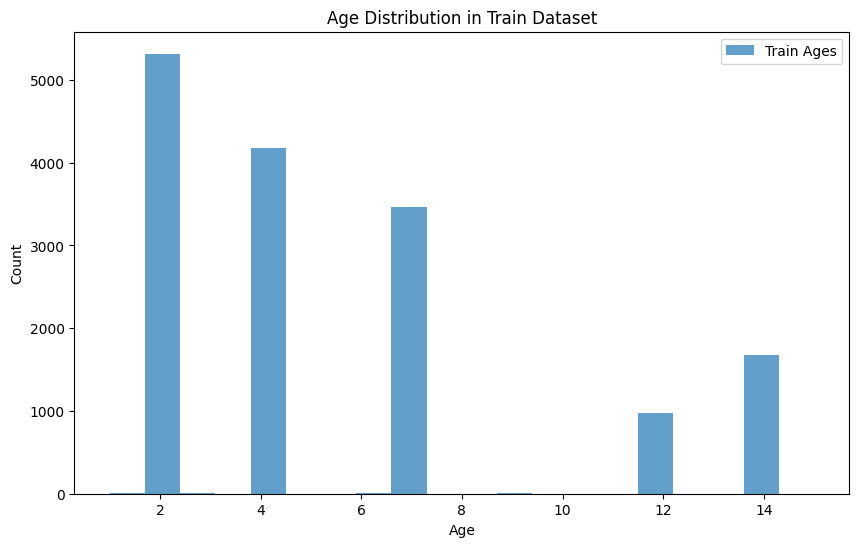

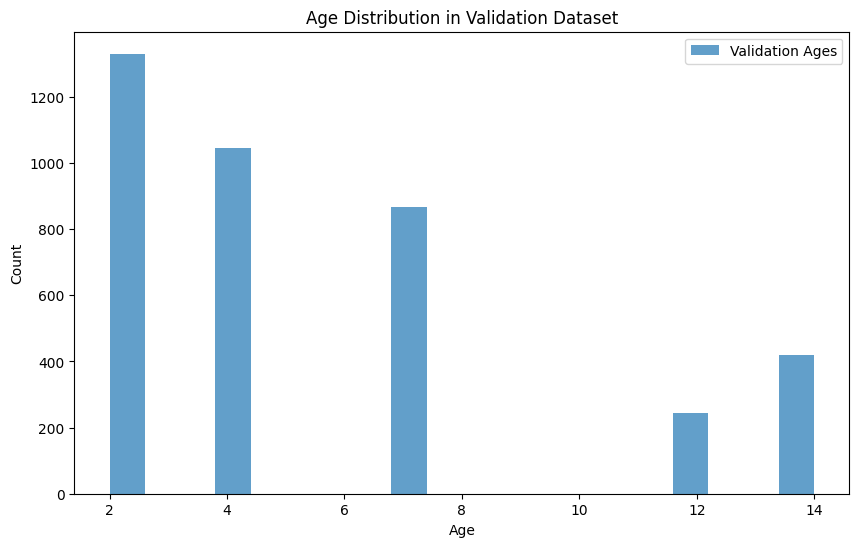

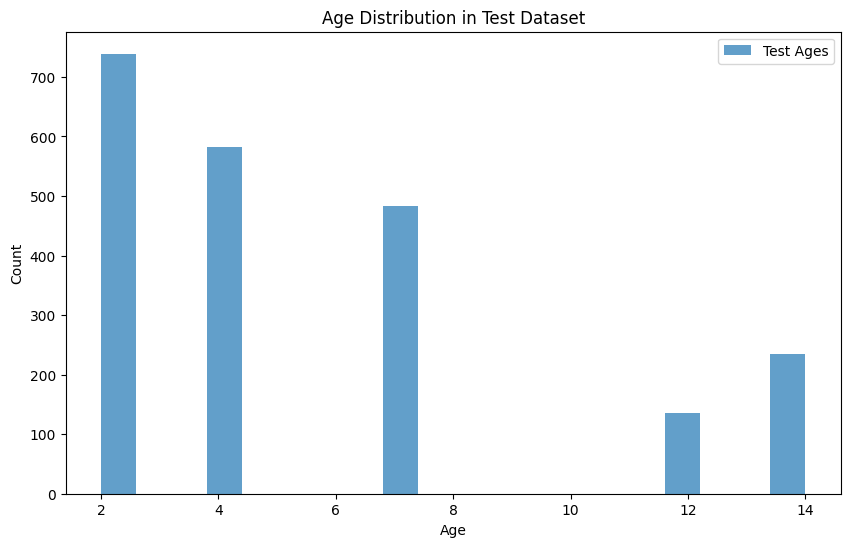

In [10]:
import matplotlib.pyplot as plt

def plot_age_distribution(ages, dataset_name):
    plt.figure(figsize=(10, 6))
    plt.hist(ages, bins=20, alpha=0.7, label=f'{dataset_name} Ages')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.title(f'Age Distribution in {dataset_name} Dataset')
    plt.legend()
    plt.show()

# Plotting the age distribution for each dataset
plot_age_distribution(train_ages, 'Train')
plot_age_distribution(val_ages, 'Validation')
plot_age_distribution(test_ages, 'Test')


In [11]:
from collections import Counter

# Assuming collect_ages_optimized is defined as above

def print_age_counts(ages, dataset_name):
    age_counts = Counter(ages)
    print(f"Age distribution in {dataset_name} dataset:")
    for age, count in sorted(age_counts.items()):
        print(f"Age {age}: {count} images")

# Collect ages
train_ages = collect_ages_optimized('./drive/MyDrive/CKWRI Deer Photos/datasets/train')
val_ages = collect_ages_optimized('./drive/MyDrive/CKWRI Deer Photos/datasets/val')
test_ages = collect_ages_optimized('./drive/MyDrive/CKWRI Deer Photos/datasets/test')

# Print age counts for each dataset
print_age_counts(train_ages, "Train")
print_age_counts(val_ages, "Validation")
print_age_counts(test_ages, "Test")


Age distribution in Train dataset:
Age 1.0: 7 images
Age 2.0: 5317 images
Age 3.0: 5 images
Age 4.0: 4182 images
Age 5.0: 2 images
Age 6.0: 4 images
Age 7.0: 3467 images
Age 8.0: 1 images
Age 9.0: 3 images
Age 12.0: 980 images
Age 13.0: 1 images
Age 14.0: 1676 images
Age 15.0: 2 images
Age distribution in Validation dataset:
Age 2.0: 1330 images
Age 4.0: 1046 images
Age 7.0: 868 images
Age 12.0: 245 images
Age 14.0: 420 images
Age distribution in Test dataset:
Age 2.0: 739 images
Age 4.0: 583 images
Age 7.0: 483 images
Age 12.0: 136 images
Age 14.0: 234 images


In [4]:
import re
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class AgeDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        # Ensure only image files are listed
        self.filenames = [f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.filenames[idx])
        image = Image.open(img_name).convert('RGB')
        basename = os.path.basename(img_name)

        # Extract the age using regex to find the last sequence of digits
        matches = re.findall(r'\d+', basename)
        if not matches:
            raise ValueError(f"No age found in filename: {img_name}")
        # The age is the last sequence of digits
        age_str = matches[-1]
        age = float(age_str)

        if self.transform:
            image = self.transform(image)

        return image, age

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assuming the paths to your dataset directories are correctly set
train_dataset = AgeDataset('./drive/MyDrive/CKWRI Deer Photos/datasets/train', transform=transform)
val_dataset = AgeDataset('./drive/MyDrive/CKWRI Deer Photos/datasets/val', transform=transform)
test_dataset = AgeDataset('./drive/MyDrive/CKWRI Deer Photos/datasets/test', transform=transform)

num_workers = 4  # or 8 as a test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)


In [21]:
from torchvision import models
import torch.nn as nn

# Load a pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the model for regression
# Replace the last layer with a new one with a single output
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

# Move the model to the GPU if available
model = model.to(device)

In [22]:
from torch import optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [23]:
import time
import copy
import numpy as np
from tqdm import tqdm

# Assuming model, criterion, optimizer, dataloaders, and device are already defined
early_stopping_patience = 5
min_val_loss = np.inf
patience_counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

num_epochs = 30
since = time.time()

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0

        # Wrap data loader with tqdm for a progress bar
        data_loader = train_loader if phase == 'train' else val_loader
        progress_bar = tqdm(data_loader, desc=f"{phase.capitalize()} Phase")

        for images, ages in progress_bar:
            images = images.to(device)
            ages = ages.to(device).view(-1, 1).float()

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(images).view(-1, 1)  # Ensure output shape matches target shape
                loss = criterion(outputs, ages)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(loss=(running_loss / len(data_loader.dataset)), refresh=True)

        epoch_loss = running_loss / len(data_loader.dataset)
        print(f'\n{phase.capitalize()} Loss: {epoch_loss:.4f}')

        # Early stopping check and update for the validation phase
        if phase == 'val':
            if epoch_loss < min_val_loss:
                min_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    print()

if patience_counter < early_stopping_patience:
    print("Early stopping did not trigger.")

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Lowest Validation Loss: {min_val_loss:.4f}')

# Load best model weights
model.load_state_dict(best_model_wts)


Epoch 0/29
----------


Train Phase: 100%|██████████| 489/489 [18:40<00:00,  2.29s/it, loss=15.5]



Train Loss: 15.4659


Val Phase: 100%|██████████| 123/123 [11:52<00:00,  5.80s/it, loss=14.7]



Val Loss: 14.6759

Epoch 1/29
----------


Train Phase: 100%|██████████| 489/489 [03:30<00:00,  2.33it/s, loss=14.1]



Train Loss: 14.1332


Val Phase: 100%|██████████| 123/123 [00:50<00:00,  2.42it/s, loss=13.9]



Val Loss: 13.8709

Epoch 2/29
----------


Train Phase: 100%|██████████| 489/489 [03:28<00:00,  2.34it/s, loss=13]



Train Loss: 12.9738


Val Phase: 100%|██████████| 123/123 [00:50<00:00,  2.42it/s, loss=29.8]



Val Loss: 29.7785

Epoch 3/29
----------


Train Phase: 100%|██████████| 489/489 [03:29<00:00,  2.34it/s, loss=11.2]



Train Loss: 11.2342


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.39it/s, loss=10.4]



Val Loss: 10.4062

Epoch 4/29
----------


Train Phase: 100%|██████████| 489/489 [03:29<00:00,  2.33it/s, loss=9.74]



Train Loss: 9.7353


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.41it/s, loss=12.2]



Val Loss: 12.2393

Epoch 5/29
----------


Train Phase: 100%|██████████| 489/489 [03:26<00:00,  2.37it/s, loss=8.6]



Train Loss: 8.6003


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.40it/s, loss=8.36]



Val Loss: 8.3592

Epoch 6/29
----------


Train Phase: 100%|██████████| 489/489 [03:30<00:00,  2.32it/s, loss=8.21]



Train Loss: 8.2100


Val Phase: 100%|██████████| 123/123 [00:50<00:00,  2.42it/s, loss=8.72]



Val Loss: 8.7171

Epoch 7/29
----------


Train Phase: 100%|██████████| 489/489 [03:27<00:00,  2.36it/s, loss=7.74]



Train Loss: 7.7388


Val Phase: 100%|██████████| 123/123 [00:50<00:00,  2.41it/s, loss=9.56]



Val Loss: 9.5619

Epoch 8/29
----------


Train Phase: 100%|██████████| 489/489 [03:27<00:00,  2.36it/s, loss=7.16]



Train Loss: 7.1575


Val Phase: 100%|██████████| 123/123 [00:50<00:00,  2.42it/s, loss=8.31]



Val Loss: 8.3130

Epoch 9/29
----------


Train Phase: 100%|██████████| 489/489 [03:29<00:00,  2.33it/s, loss=6.71]



Train Loss: 6.7063


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.40it/s, loss=8.4]



Val Loss: 8.4028

Epoch 10/29
----------


Train Phase: 100%|██████████| 489/489 [03:28<00:00,  2.35it/s, loss=6.29]



Train Loss: 6.2946


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.41it/s, loss=9.29]



Val Loss: 9.2942

Epoch 11/29
----------


Train Phase: 100%|██████████| 489/489 [03:28<00:00,  2.35it/s, loss=5.94]



Train Loss: 5.9355


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.40it/s, loss=8.3]



Val Loss: 8.3031

Epoch 12/29
----------


Train Phase: 100%|██████████| 489/489 [03:27<00:00,  2.36it/s, loss=5.36]



Train Loss: 5.3554


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.39it/s, loss=7.13]



Val Loss: 7.1310

Epoch 13/29
----------


Train Phase: 100%|██████████| 489/489 [03:29<00:00,  2.33it/s, loss=4.95]



Train Loss: 4.9500


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.38it/s, loss=6.7]



Val Loss: 6.6990

Epoch 14/29
----------


Train Phase: 100%|██████████| 489/489 [03:27<00:00,  2.36it/s, loss=4.68]



Train Loss: 4.6824


Val Phase: 100%|██████████| 123/123 [00:52<00:00,  2.36it/s, loss=6.13]



Val Loss: 6.1329

Epoch 15/29
----------


Train Phase: 100%|██████████| 489/489 [03:29<00:00,  2.33it/s, loss=4.17]



Train Loss: 4.1664


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.39it/s, loss=6.15]



Val Loss: 6.1457

Epoch 16/29
----------


Train Phase: 100%|██████████| 489/489 [03:32<00:00,  2.30it/s, loss=4.04]



Train Loss: 4.0405


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.40it/s, loss=7.58]



Val Loss: 7.5834

Epoch 17/29
----------


Train Phase: 100%|██████████| 489/489 [03:30<00:00,  2.33it/s, loss=3.38]



Train Loss: 3.3823


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.39it/s, loss=6.53]



Val Loss: 6.5320

Epoch 18/29
----------


Train Phase: 100%|██████████| 489/489 [03:30<00:00,  2.33it/s, loss=2.99]



Train Loss: 2.9881


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.41it/s, loss=8.92]



Val Loss: 8.9232

Epoch 19/29
----------


Train Phase: 100%|██████████| 489/489 [03:30<00:00,  2.32it/s, loss=2.7]



Train Loss: 2.7042


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.40it/s, loss=6.28]



Val Loss: 6.2777
Early stopping triggered.

Epoch 20/29
----------


Train Phase: 100%|██████████| 489/489 [03:28<00:00,  2.34it/s, loss=2.36]



Train Loss: 2.3635


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.40it/s, loss=5.7]



Val Loss: 5.7020

Epoch 21/29
----------


Train Phase: 100%|██████████| 489/489 [03:32<00:00,  2.30it/s, loss=2.17]



Train Loss: 2.1672


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.40it/s, loss=6]



Val Loss: 6.0027

Epoch 22/29
----------


Train Phase: 100%|██████████| 489/489 [03:29<00:00,  2.33it/s, loss=2]



Train Loss: 1.9983


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.38it/s, loss=6.23]



Val Loss: 6.2293

Epoch 23/29
----------


Train Phase: 100%|██████████| 489/489 [03:27<00:00,  2.36it/s, loss=1.8]



Train Loss: 1.8047


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.39it/s, loss=5.97]



Val Loss: 5.9661

Epoch 24/29
----------


Train Phase: 100%|██████████| 489/489 [03:29<00:00,  2.33it/s, loss=1.52]



Train Loss: 1.5197


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.41it/s, loss=5.57]



Val Loss: 5.5666

Epoch 25/29
----------


Train Phase: 100%|██████████| 489/489 [03:30<00:00,  2.32it/s, loss=1.49]



Train Loss: 1.4881


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.39it/s, loss=5.66]



Val Loss: 5.6592

Epoch 26/29
----------


Train Phase: 100%|██████████| 489/489 [03:31<00:00,  2.32it/s, loss=1.68]



Train Loss: 1.6752


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.40it/s, loss=6.82]



Val Loss: 6.8200

Epoch 27/29
----------


Train Phase: 100%|██████████| 489/489 [03:28<00:00,  2.34it/s, loss=1.39]



Train Loss: 1.3908


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.37it/s, loss=5.55]



Val Loss: 5.5507

Epoch 28/29
----------


Train Phase: 100%|██████████| 489/489 [03:30<00:00,  2.32it/s, loss=1.21]



Train Loss: 1.2085


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.41it/s, loss=5.74]



Val Loss: 5.7412

Epoch 29/29
----------


Train Phase: 100%|██████████| 489/489 [03:27<00:00,  2.35it/s, loss=1.09]



Train Loss: 1.0884


Val Phase: 100%|██████████| 123/123 [00:51<00:00,  2.39it/s, loss=6.34]


Val Loss: 6.3381

Early stopping did not trigger.
Training complete in 156m 32s
Lowest Validation Loss: 5.5507


<All keys matched successfully>

The best model weights would be saved for the epoch that achieved the lowest validation loss throughout the training process.

From the log:

The Lowest Validation Loss reported is 5.5507.
This lowest validation loss occurred at Epoch 27.
Hence, the model state (best_model_wts) saved is from Epoch 27, which corresponds to the lowest validation loss observed during the training. This state is what your script would use to "Load best model weights" at the end of the training session:

In [24]:
# Comprehensive save
checkpoint = {
    'epoch': epoch + 1,  # Number of epochs completed
    'state_dict': model.state_dict(),  # Model parameters
    'optimizer': optimizer.state_dict(),  # Optimizer parameters
    'best_val_loss': min_val_loss,  # Best validation loss observed
    # Add other information you might need for resuming training or evaluation
}

# Choose a path and filename
checkpoint_save_path = './drive/MyDrive/CKWRI Deer Photos/model_checkpoint.pth'
torch.save(checkpoint, checkpoint_save_path)

print(f'Model and training state saved to "{checkpoint_save_path}"')


Model and training state saved to "./drive/MyDrive/CKWRI Deer Photos/model_checkpoint.pth"


In [25]:
model_save_path = './drive/MyDrive/CKWRI Deer Photos/best_model_weights.pth'

# Save the best model weights to Google Drive
torch.save(best_model_wts, model_save_path)
print(f'Model saved to "{model_save_path}"')


Model saved to "./drive/MyDrive/CKWRI Deer Photos/best_model_weights.pth"


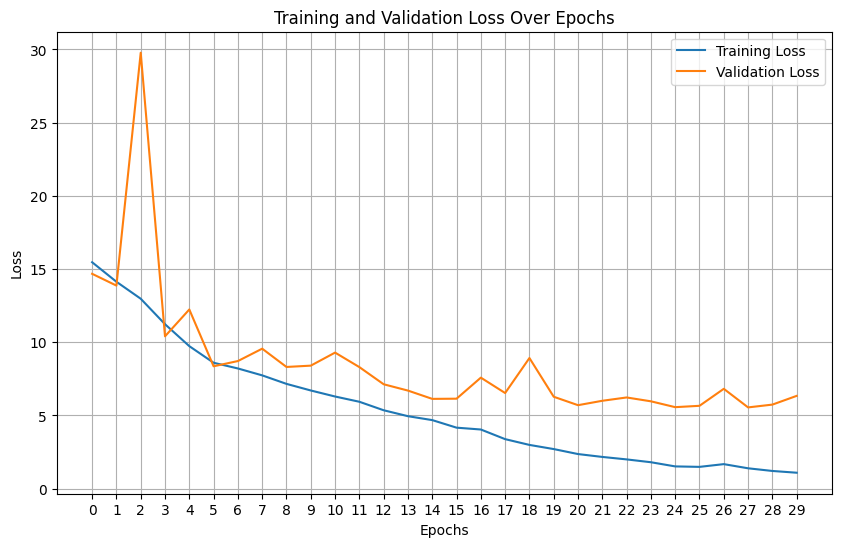

In [26]:
import matplotlib.pyplot as plt

# Manually recorded training and validation losses
train_losses = [
    15.4659, 14.1332, 12.9738, 11.2342, 9.7353,
    8.6003, 8.2100, 7.7388, 7.1575, 6.7063,
    6.2946, 5.9355, 5.3554, 4.9500, 4.6824,
    4.1664, 4.0405, 3.3823, 2.9881, 2.7042,
    2.3635, 2.1672, 1.9983, 1.8047, 1.5197,
    1.4881, 1.6752, 1.3908, 1.2085, 1.0884
]

val_losses = [
    14.6759, 13.8709, 29.7785, 10.4062, 12.2393,
    8.3592, 8.7171, 9.5619, 8.3130, 8.4028,
    9.2942, 8.3031, 7.1310, 6.6990, 6.1329,
    6.1457, 7.5834, 6.5320, 8.9232, 6.2777,
    5.7020, 6.0027, 6.2293, 5.9661, 5.5666,
    5.6592, 6.8200, 5.5507, 5.7412, 6.3381
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.xticks(range(0, len(train_losses)))  # Ensure x-axis ticks match the number of epochs
plt.show()


In [7]:
from torchvision import models
import torch.nn as nn
import torch
from torch import optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from tqdm import tqdm

# Assuming 'device' is defined (e.g., device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Re-create the same model architecture
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model = model.to(device)

# Load the best model weights
model_save_path = './drive/MyDrive/CKWRI Deer Photos/best_model_weights.pth'
model.load_state_dict(torch.load(model_save_path, map_location=device))

# Set the model to evaluation mode
model.eval()

# Define the loss criterion
criterion = nn.MSELoss()

# Initialize lists to store true ages and predicted ages
actuals = []
predictions = []

# Track test loss for averaging
test_loss = 0.0

with torch.no_grad():
    for images, ages in tqdm(test_loader, desc="Testing Phase"):
        images = images.to(device)
        ages = ages.to(device).view(-1, 1).float()

        outputs = model(images).view(-1, 1)

        # Calculate loss
        loss = criterion(outputs, ages)
        test_loss += loss.item() * images.size(0)

        # Store actual and predicted values for later evaluation
        actuals.extend(ages.cpu().numpy())
        predictions.extend(outputs.cpu().numpy())

# Calculate average loss
test_loss /= len(test_loader.dataset)

# Calculate MAE and RMSE
actuals = np.array(actuals).flatten()
predictions = np.array(predictions).flatten()
mae = mean_absolute_error(actuals, predictions)
rmse = sqrt(mean_squared_error(actuals, predictions))

print(f'Test Loss: {test_loss:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')


Testing Phase: 100%|██████████| 68/68 [02:05<00:00,  1.84s/it]

Test Loss: 5.2934
Mean Absolute Error (MAE): 1.4709
Root Mean Squared Error (RMSE): 2.3007


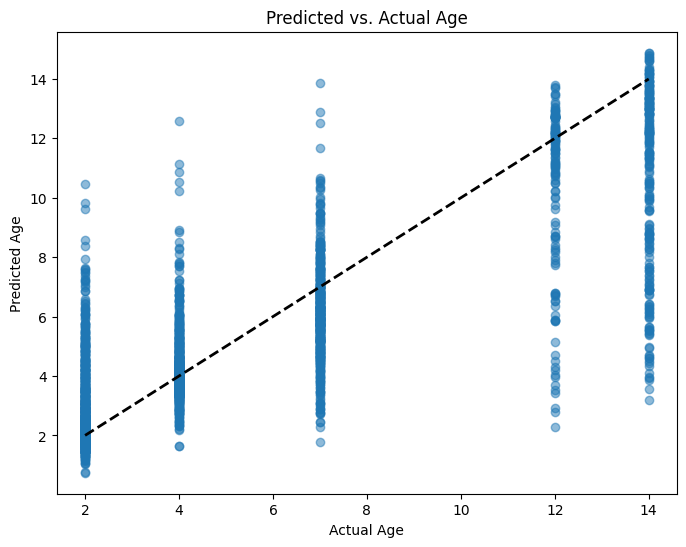

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Predicted vs. Actual Age')
plt.show()


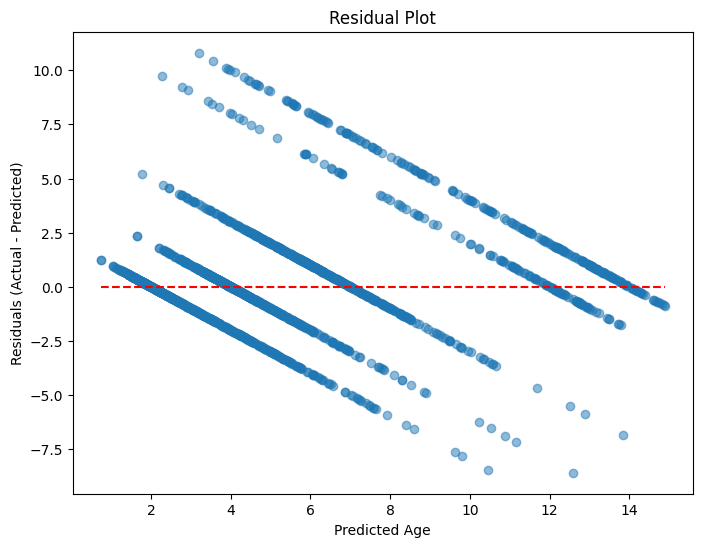

In [9]:
residuals = np.array(actuals) - np.array(predictions)

plt.figure(figsize=(8, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Age')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()


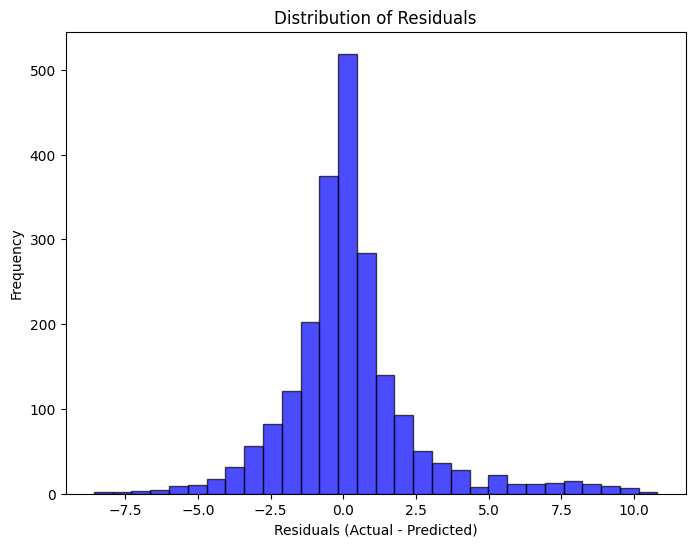

In [10]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

#Change to categories and see the performance

In [9]:
from torchvision import models
import torch.nn as nn
import torch
from torch import optim
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model = model.to(device)

model_save_path = './drive/MyDrive/CKWRI Deer Photos/best_model_weights.pth'
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

def map_age_to_category(age):
    """Maps continuous age to categorical label."""
    if age <= 5:
        return '0-5'
    elif age <= 10:
        return '0-10'
    else:
        return 'older than 10'

categorized_actuals = []
categorized_predictions = []

with torch.no_grad():
    for images, ages in tqdm(test_loader, desc="Testing Phase"):
        images = images.to(device)
        # Convert ages to categories based on provided bins
        categorized_actual_ages = [map_age_to_category(age.item()) for age in ages]

        outputs = model(images).view(-1).cpu().numpy()
        categorized_predicted_ages = [map_age_to_category(prediction) for prediction in outputs]

        categorized_actuals.extend(categorized_actual_ages)
        categorized_predictions.extend(categorized_predicted_ages)

# Calculate Accuracy
accuracy = accuracy_score(categorized_actuals, categorized_predictions)

# Classification Report
report = classification_report(categorized_actuals, categorized_predictions, target_names=['young', 'mature', 'old'])

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Testing Phase: 100%|██████████| 68/68 [00:28<00:00,  2.41it/s]

Accuracy: 0.7917
Classification Report:
              precision    recall  f1-score   support

       young       0.55      0.76      0.64       483
      mature       0.89      0.84      0.87      1322
         old       0.93      0.65      0.77       370

    accuracy                           0.79      2175
   macro avg       0.79      0.75      0.76      2175
weighted avg       0.82      0.79      0.80      2175



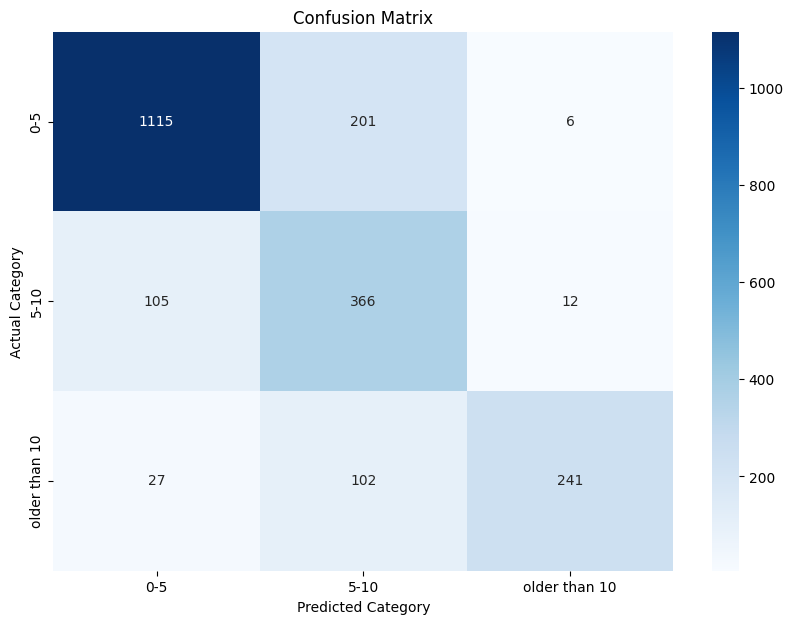

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming categorized_actuals and categorized_predictions are populated as in the previous step

# Compute the confusion matrix
cm = confusion_matrix(categorized_actuals, categorized_predictions, labels=['0-5', '0-10', 'older than 10'])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['0-5', '5-10', 'older than 10'], yticklabels=['0-5', '5-10', 'older than 10'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.show()
